In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import os
from pathlib import Path

# 0. Camera calibration 

RGB_D camera of intel realsense D435

### 0.1 OV9282 sensor and Focus
1. image area : 3896 x 2453 µm
2. pixel size : 3.0 µm
3. focal lenth 1.93mm

### 0.2 matrix
width: 640, height: 480, ppx: 327.327, ppy: 239.649, fx: 620.423, fy: 620.95, model: Brown Conrady

In [18]:
mtx = np.array([
    [620.423,0,327.327],
    [0,620.95,239.649],
    [0,0,1]
])

# 1. Track camera position by RGB_D camera

## process
1. feature points extraction

2. feature points matching

3. Correspondences Outlier Rejection, and delete points with no depth information

4. 6D Rigid Motion Estimation

In [20]:
# shape of the depth
imageHeight = 480
imageWidth = 640

In [21]:
## detection and matching of feature points
def feature_points_detection_and_matching(image1, image2,param =0.55):
    # resize image
    image1 = cv2.resize(image1, (imageWidth, imageHeight))
    image2 = cv2.resize(image2, (imageWidth, imageHeight))    
    # feature points detection
    sift = cv2.xfeatures2d.SURF_create()
    kp1, des1 = sift.detectAndCompute(image1,None)
    kp2, des2 = sift.detectAndCompute(image2,None)
    # feature points matching 
    # FLANN parameters
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    pts1 = []
    pts2 = []
    matchesMask = [[0,0] for i in range(len(matches))]
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < param*n.distance:
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
            matchesMask[i]=[1,0]
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return pts1, pts2

In [22]:
## delete the points without depth information
def delete_no_depth_points(pts1, pts2, depth1, depth2, mtx):
    number = len(pts1)
    fin_pts1 = []
    fin_pts2 = []
    for i in range(number):
        dep1 = depth1[pts1[i][1],pts1[i][0]]
        dep2 = depth2[pts2[i][1],pts2[i][0]]
        if dep1*dep2 != 0:
            img_p1 = np.array([pts1[i][1], pts1[i][0], 1])
            real_p1 = np.dot(np.linalg.inv(mtx),(img_p1)*dep1)
            fin_pts1.append(real_p1)
            img_p2 = np.array([pts2[i][1], pts2[i][0], 1])
            real_p2 = np.dot(np.linalg.inv(mtx),(img_p2)*dep2)
            fin_pts2.append(real_p2)
    fin_pts1 = np.asarray(fin_pts1).reshape((1,-1,3)).astype(np.float32)
    fin_pts2 = np.asarray(fin_pts2).reshape((1,-1,3)).astype(np.float32)
    return fin_pts1, fin_pts2

In [28]:
## caluculate the rigid body transformation matrix from two sets of points
def rigid_transform_3D(pts1, pts2):
    A = pts1.reshape(-1,3)
    B = pts2.reshape(-1,3)
    # Input: expects Nx3 matrix of points
    assert len(A) == len(B)
    N = A.shape[0]; # total points
    centroid_A = np.mean(A, axis=0)
    centroid_B = np.mean(B, axis=0)
    # centre the points
    AA = A - np.tile(centroid_A, (N, 1))
    BB = B - np.tile(centroid_B, (N, 1))
    # dot is matrix multiplication for array
    H = np.dot(np.transpose(AA),BB)
    U, S, Vt = np.linalg.svd(H)
    R = np.dot(Vt.T, U.T)
    # special reflection case
    if np.linalg.det(R) < 0:
        Vt[2,:] *= -1
        R = np.dot(Vt.T, U.T)
    t = -np.dot(R,centroid_A.T) + centroid_B.T
    M = np.zeros((3,4))
    M[0:3,0:3] = R
    M[:,3] = t
    return M

In [33]:
## make points cloudy for meshlab
def vert_new(img,D, T,K, if_inv = False):
    l = img.shape[0]
    h = img.shape[1]
    t = 0
    temp = np.zeros((l*h, 6))
    T = np.concatenate((T, np.array([[0,0,0,1]])), axis=0)
    if if_inv:
        T = np.linalg.inv(T)

    for i in range(l):
        for j in range(h):
            dep = D[i,j]
            if 0.0 <dep< 6000:
                #camera caliberation
                img_p = np.array([i, j, 1])
                real_p = np.dot(np.linalg.inv(K),(img_p)*dep)
                real_p = np.append(real_p, 1)
                #real_p[1] = - real_p[1]
                aa = np.dot(T, real_p).reshape(1,4)
                temp[t,0:3]  = aa[0,0:3]/aa[0,3]
                temp[t,3:6] = img[i,j]
                t = t+1
    return temp[0:t,:]

In [13]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar blue
property uchar green
property uchar red
end_header
'''
def write_ply(fn,verts ):
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d')

In [48]:
def get_inliers_pts(pts, inliers):
    out = []
    for i in range(len(inliers)):
        if inliers[i] == 1:
            out.append(pts[0,i,:])
    return np.asarray(out).reshape((1,-1,3)).astype(np.float32)

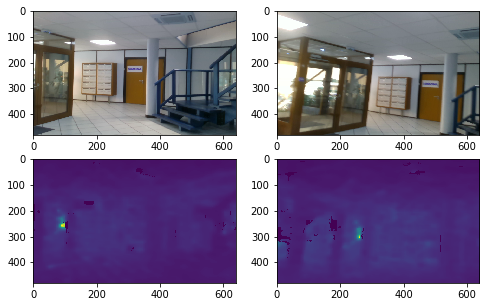

In [65]:
## show some exaple of images
image1 = np.load('F:/pfe_2/realsense/frames/rgb/'+str(i).zfill(3)+'.npy')
image2 = np.load('F:/pfe_2/realsense/frames/rgb/'+str(i+1).zfill(3)+'.npy')
depth1 = np.load('F:/pfe_2/realsense/frames/d/'+str(i).zfill(3)+'.npy')
depth2 = np.load('F:/pfe_2/realsense/frames/d/'+str(i+1).zfill(3)+'.npy')
plt.figure(figsize = (8,5))
plt.subplot(221); plt.imshow(image1,aspect='auto')
plt.subplot(222); plt.imshow(image2,aspect='auto')
plt.subplot(223); plt.imshow(depth1,aspect='auto')
plt.subplot(224); plt.imshow(depth2,aspect='auto')

In [45]:
## test of the functions above
pts1, pts2 = feature_points_detection_and_matching(image1, image2,param =0.55)
pts1, pts2 = delete_no_depth_points(pts1, pts2, depth1, depth2, mtx)

retval, M_cv, inliers = cv2.estimateAffine3D(pts2, pts1, ransacThreshold=12)
M_rigid = rigid_transform_3D(pts1, pts2)
print(M_cv)
print(M_rigid)

[[ 1.06867877e+00  1.16026299e-01  2.03004982e-01 -8.29193718e+02]
 [-2.75070969e-01  7.93426313e-01  4.86643075e-02  1.36266909e+03]
 [-4.15108787e-01 -4.90715280e-01  2.96020162e-01  2.92310277e+03]]
[[ 9.92342889e-01 -8.09708089e-02 -9.32707563e-02  4.93518188e+02]
 [ 5.36409281e-02  9.62735832e-01 -2.65070409e-01 -5.41509827e+02]
 [ 1.11258060e-01  2.58037537e-01  9.59707379e-01  1.84088867e+02]]


E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ushort_scalars
  


In [50]:
## test of the inliers
pts1 = get_inliers_pts(pts1, inliers)
pts2 = get_inliers_pts(pts2, inliers)
M_rigid = rigid_transform_3D(pts1, pts2)
print(M_rigid)

[[ 9.84510601e-01 -1.11074984e-01 -1.35650724e-01  7.35646606e+02]
 [ 9.21751335e-02  9.86071110e-01 -1.38447002e-01 -1.26470129e+03]
 [ 1.49139240e-01  1.23798907e-01  9.81035829e-01  4.89755859e+02]]


In [34]:
# see the test result with 2 rgbd images
res1 = vert_new(image1,depth1, np.eye(3,4), mtx)
res2 = vert_new(image2,depth2, M_cv, mtx)
res3 = vert_new(image2,depth2, M_rigid, mtx, True)
write_ply('test1.ply', res1)
write_ply('test2.ply', res2)
write_ply('test3.ply', res3)
## the result is terrific

In [51]:
# multiplation of 2 transformation matrix
def matrix_multi(M_new, M_old):
    M_new = np.concatenate((M_new, np.array([[0,0,0,1]])), axis=0)
    M_old = np.concatenate((M_old, np.array([[0,0,0,1]])), axis=0)
    return np.dot(M_new, M_old)[0:3,:]

In [62]:
# get ply file from several(num) rgbd images
def ply_for_n_images(num, start, mtx):
    image1 = np.load('F:/pfe_2/realsense/frames/rgb/'+str(start).zfill(3)+'.npy')
    depth1 = np.load('F:/pfe_2/realsense/frames/d/'+str(start).zfill(3)+'.npy')
    M_rigid_old = np.eye(3,4)
    res1 = vert_new(image1,depth1, M_rigid_old, mtx)
    write_ply('test0.ply', res1)
    for i in range(num):
        image2 = np.load('F:/pfe_2/realsense/frames/rgb/'+str(start+i+1).zfill(3)+'.npy')
        depth2 = np.load('F:/pfe_2/realsense/frames/d/'+str(start+i+1).zfill(3)+'.npy')
        pts1, pts2 = feature_points_detection_and_matching(image1, image2,param =0.55)
        pts1, pts2 = delete_no_depth_points(pts1, pts2, depth1, depth2, mtx)
        #retval, M_cv, inliers = cv2.estimateAffine3D(pts2, pts1, ransacThreshold=12)
        #pts1 = get_inliers_pts(pts1, inliers)
        #pts2 = get_inliers_pts(pts2, inliers)
        M_rigid_new = rigid_transform_3D(pts1, pts2)
        M_rigid_old = matrix_multi(M_rigid_new, M_rigid_old)
        
        res1 = vert_new(image2,depth2, M_rigid_old, mtx, True)
        print('  drawn one image')
        write_ply('test'+str(i+1)+'.ply', res1)
        image1 = image2
        depth1 = depth2
    print('----- finished -----')
    return 0
        

In [63]:
# final test
ply_for_n_images(8, 12, mtx)

E:\program\Anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in ushort_scalars
  


  drawn one image
  drawn one image
  drawn one image
  drawn one image
  drawn one image
  drawn one image
  drawn one image
  drawn one image
----- finished -----


0

### test result

part of the result
![title](img/1.PNG)
second part of the result
![title](img/2.PNG)
fully shown
![title](img/3.PNG)